# CNN on Covid 19 X Ray Images

In [ ]:
# Import the required libraries/modules for loading the X ray image files from Kaggle

! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [223]:
# Import the required libraries/modules for other purposes

%tensorflow_version 2.x
import tensorflow as tf
import zipfile
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from numpy import random

In [ ]:
# Download the dataset from Kaggle

! kaggle datasets download -d prashant268/chest-xray-covid19-pneumonia

100% 2.05G/2.06G [00:26<00:00, 64.1MB/s]
100% 2.06G/2.06G [00:26<00:00, 84.4MB/s]


In [ ]:
# Unzip the image files

# Specify the location of the source (zipped file) and the target directory
file_zip = "/content/chest-xray-covid19-pneumonia.zip"
target_directory = "/content/covid19"

# Command for extraction
zipfile.ZipFile(file_zip).extractall(target_directory)

**Note:**

The covid19 folder now contains the unzipped Data folder.

Within Data, there are 2 sub folders: train and test

Within each of the sub folders, there are 3 sub folders titled COVID19, NORMAL, PNEUMONIA - these are the class labels

In [ ]:
# Compose the image data pipeline for use in CNN
# Use Image Data Generator framework for:
# 1. Image augmentation
# 2. Rescaling the intensity values at pixels
# 3. Converting image files within the folder structure in to their numeric representation
# 4. Size the batches based on batch size
# 5. Repeat the process for the test dataset as well

batch_size       = 64
train_directory  = "/content/covid19/Data/train"
test_directory   = "/content/covid19/Data/test"

IDG = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range = 20,
                                                      width_shift_range = 0.10,
                                                      height_shift_range = 0.10,
                                                      rescale = 1/255,
                                                      shear_range = 0.1,
                                                      zoom_range = 0.1,
                                                      horizontal_flip = True,
                                                      fill_mode = 'nearest')
# For train dataset
IDG_train = IDG.flow_from_directory(train_directory,
                                    target_size = (100,100),
                                    color_mode = 'grayscale',
                                    batch_size = batch_size,
                                    class_mode = 'categorical')

# For test dataset
IDG_test = IDG.flow_from_directory(test_directory,
                                    target_size = (100,100),
                                    color_mode = 'grayscale',
                                    batch_size = batch_size,
                                    class_mode = 'categorical',
                                    shuffle = False)

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


**Note:**

The train and test images are now ready.

We shall now proceed with model building.

In [ ]:
# Compose the CNN architecture

# Use the sequential API
cnn_covidxray_model = Sequential()

# Add 3 conv layers with filters 128, 64 and 32 respectively with a pool size of 2 x 2

# Conv layer 1
cnn_covidxray_model.add(Conv2D(128, (3, 3), activation="relu", input_shape=(100, 100, 1)))

# Max pooling layer 1
cnn_covidxray_model.add(MaxPooling2D(pool_size = (2, 2)))

# Conv layer 2
cnn_covidxray_model.add(Conv2D(64, (3, 3), activation="relu", input_shape=(100, 100, 1)))

# Max pooling layer 2
cnn_covidxray_model.add(MaxPooling2D(pool_size = (2, 2)))

# Conv layer 3
cnn_covidxray_model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(100, 100, 1)))

# Max pooling layer 3
cnn_covidxray_model.add(MaxPooling2D(pool_size = (2, 2)))

# Add a flattening layer
cnn_covidxray_model.add(Flatten())

# Add FC layer of 64 units
cnn_covidxray_model.add(Dense(activation = 'relu', units = 64))

# Specify the output layer of 3 units with softmax activation
cnn_covidxray_model.add(Dense(activation = 'softmax', units = 3))

# Summarize the model
cnn_covidxray_model.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_188 (Conv2D)          (None, 98, 98, 128)       1280      
_________________________________________________________________
max_pooling2d_182 (MaxPoolin (None, 49, 49, 128)       0         
_________________________________________________________________
conv2d_189 (Conv2D)          (None, 47, 47, 64)        73792     
_________________________________________________________________
max_pooling2d_183 (MaxPoolin (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_190 (Conv2D)          (None, 21, 21, 32)        18464     
_________________________________________________________________
max_pooling2d_184 (MaxPoolin (None, 10, 10, 32)        0         
_________________________________________________________________
flatten_36 (Flatten)         (None, 3200)            

In [ ]:
# Specify the required callback

# Early stopping
ES = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)

# Compose a list of callbacks
CB_list = [ES]

# Compile the model by specifying the optimizer along with the loss and metrics to use
cnn_covidxray_model.compile(optimizer = tf.keras.optimizers.Adam(), 
                            loss = 'categorical_crossentropy', 
                            metrics = ['accuracy'])

In [ ]:
# Fit the model (Epochs 1 to 10)

cnn_covidxray_model.fit(IDG_train, validation_data = IDG_test, 
                        epochs = 10, callbacks = CB_list)

Epoch 1/10
81/81 [==============================] - 150s 2s/step - loss: 0.8429 - accuracy: 0.6743 - val_loss: 0.5060 - val_accuracy: 0.8028
Epoch 2/10
81/81 [==============================] - 147s 2s/step - loss: 0.5303 - accuracy: 0.7817 - val_loss: 0.4166 - val_accuracy: 0.8284
Epoch 3/10
81/81 [==============================] - 148s 2s/step - loss: 0.4051 - accuracy: 0.8319 - val_loss: 0.3330 - val_accuracy: 0.8602
Epoch 4/10
81/81 [==============================] - 147s 2s/step - loss: 0.3630 - accuracy: 0.8663 - val_loss: 0.3290 - val_accuracy: 0.8672
Epoch 5/10
81/81 [==============================] - 148s 2s/step - loss: 0.3609 - accuracy: 0.8622 - val_loss: 0.3039 - val_accuracy: 0.8859
Epoch 6/10
81/81 [==============================] - 146s 2s/step - loss: 0.3340 - accuracy: 0.8640 - val_loss: 0.2930 - val_accuracy: 0.8890
Epoch 7/10
81/81 [==============================] - 147s 2s/step - loss: 0.3147 - accuracy: 0.8768 - val_loss: 0.2540 - val_accuracy: 0.9068
Epoch 8/10
81

In [ ]:
# Fit the model (Epochs 11 to 20)

cnn_covidxray_model.fit(IDG_train, validation_data = IDG_test, 
                        epochs = 10, callbacks = CB_list)

Epoch 1/10
81/81 [==============================] - 149s 2s/step - loss: 0.2398 - accuracy: 0.9135 - val_loss: 0.2213 - val_accuracy: 0.9193
Epoch 2/10
81/81 [==============================] - 147s 2s/step - loss: 0.2258 - accuracy: 0.9156 - val_loss: 0.2169 - val_accuracy: 0.9224
Epoch 3/10
81/81 [==============================] - 147s 2s/step - loss: 0.2164 - accuracy: 0.9217 - val_loss: 0.2060 - val_accuracy: 0.9309
Epoch 4/10
81/81 [==============================] - 147s 2s/step - loss: 0.2107 - accuracy: 0.9213 - val_loss: 0.2165 - val_accuracy: 0.9278
Epoch 5/10
81/81 [==============================] - 147s 2s/step - loss: 0.1968 - accuracy: 0.9273 - val_loss: 0.1965 - val_accuracy: 0.9270
Epoch 6/10
81/81 [==============================] - 147s 2s/step - loss: 0.1972 - accuracy: 0.9285 - val_loss: 0.2156 - val_accuracy: 0.9177
Epoch 7/10
81/81 [==============================] - 147s 2s/step - loss: 0.2075 - accuracy: 0.9250 - val_loss: 0.2054 - val_accuracy: 0.9161
Epoch 8/10
81

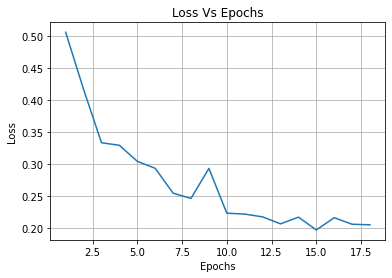

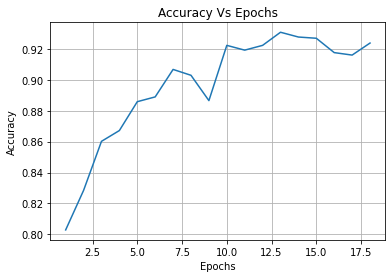

In [202]:
# Plot the learning rate & accuracy as a function of epochs

validation_accuracy = [0.8028, 0.8284, 0.8602, 0.8672, 0.8859, 0.8890, 0.9068, 0.9030, 0.8866, 0.9224, 0.9193, 0.9224, 0.9309, 0.9278, 0.9270, 0.9177, 0.9161, 0.9239]
validation_loss = [0.5060, 0.4166, 0.3330, 0.3290, 0.3039, 0.2930, 0.2540, 0.2458, 0.2928, 0.2227, 0.2213, 0.2169, 0.2060, 0.2165, 0.1965, 0.2156, 0.2054, 0.2045]
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

# Plot loss vs epochs
plt.plot(epochs, validation_loss)
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Loss Vs Epochs")
plt.grid()
plt.show()

print("\n")

# Plot accuracy vs epochs
plt.plot(epochs, validation_accuracy)
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title("Accuracy Vs Epochs")
plt.grid()
plt.show()

In [211]:
# Analysis of performance on test dataset

# 1. Test accuracy
print("\nTest Accuracy: ", 100 * cnn_covidxray_model.evaluate(IDG_test)[1], "%\n" )


21/21 [==============================] - 29s 1s/step - loss: 0.1957 - accuracy: 0.9317

Test Accuracy:  93.16770434379578 %



In [ ]:
# Calculate the probabilities on test dataset
pred_prob = cnn_covidxray_model.predict(IDG_test, verbose=1)

In [216]:
# Convert probabilities to classes

pred_classes = []

for i in pred_prob:
  pred_classes.append(np.argmax(i))

In [ ]:
# Construct the confusion matrix
confusion_matrix = pd.DataFrame(data = confusion_matrix(IDG_test.classes, pred_classes, labels=[0, 1, 2]),
                                index = ["Actual COVID19", "Actual NORMAL", " Actual Pneumonia"],
                                columns=["Predicted COVID19", "Predicted NORMAL", "Predicted Pneumonia"])


Classification Metrics...

              precision    recall  f1-score   support

     COVID19       0.96      0.91      0.93       116
      NORMAL       0.86      0.87      0.87       317
   PNEUMONIA       0.95      0.96      0.95       855

    accuracy                           0.93      1288
   macro avg       0.93      0.91      0.92      1288
weighted avg       0.93      0.93      0.93      1288


Confusion Matrix...



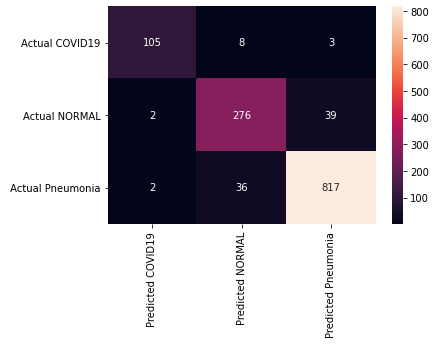

In [222]:
# 2. Print the classification metrics
print("\nClassification Metrics...\n")
print(classification_report(y_true = IDG_test.classes, y_pred = pred_classes,
                            target_names =['COVID19', 'NORMAL', 'PNEUMONIA']))

# 3. Plot the confusion matrix as a heatmap
print("\nConfusion Matrix...\n")
sns.heatmap(confusion_matrix, annot = True, fmt = "d")

In [ ]:
# Reset the test dataset
IDG_test.reset()

# Extract the images and labels from the test dataset
Image = np.concatenate([IDG_test.next()[0] for i in range(IDG_test.__len__())])
Label = np.concatenate([IDG_test.next()[1] for i in range(IDG_test.__len__())])


Sample images check from test data....



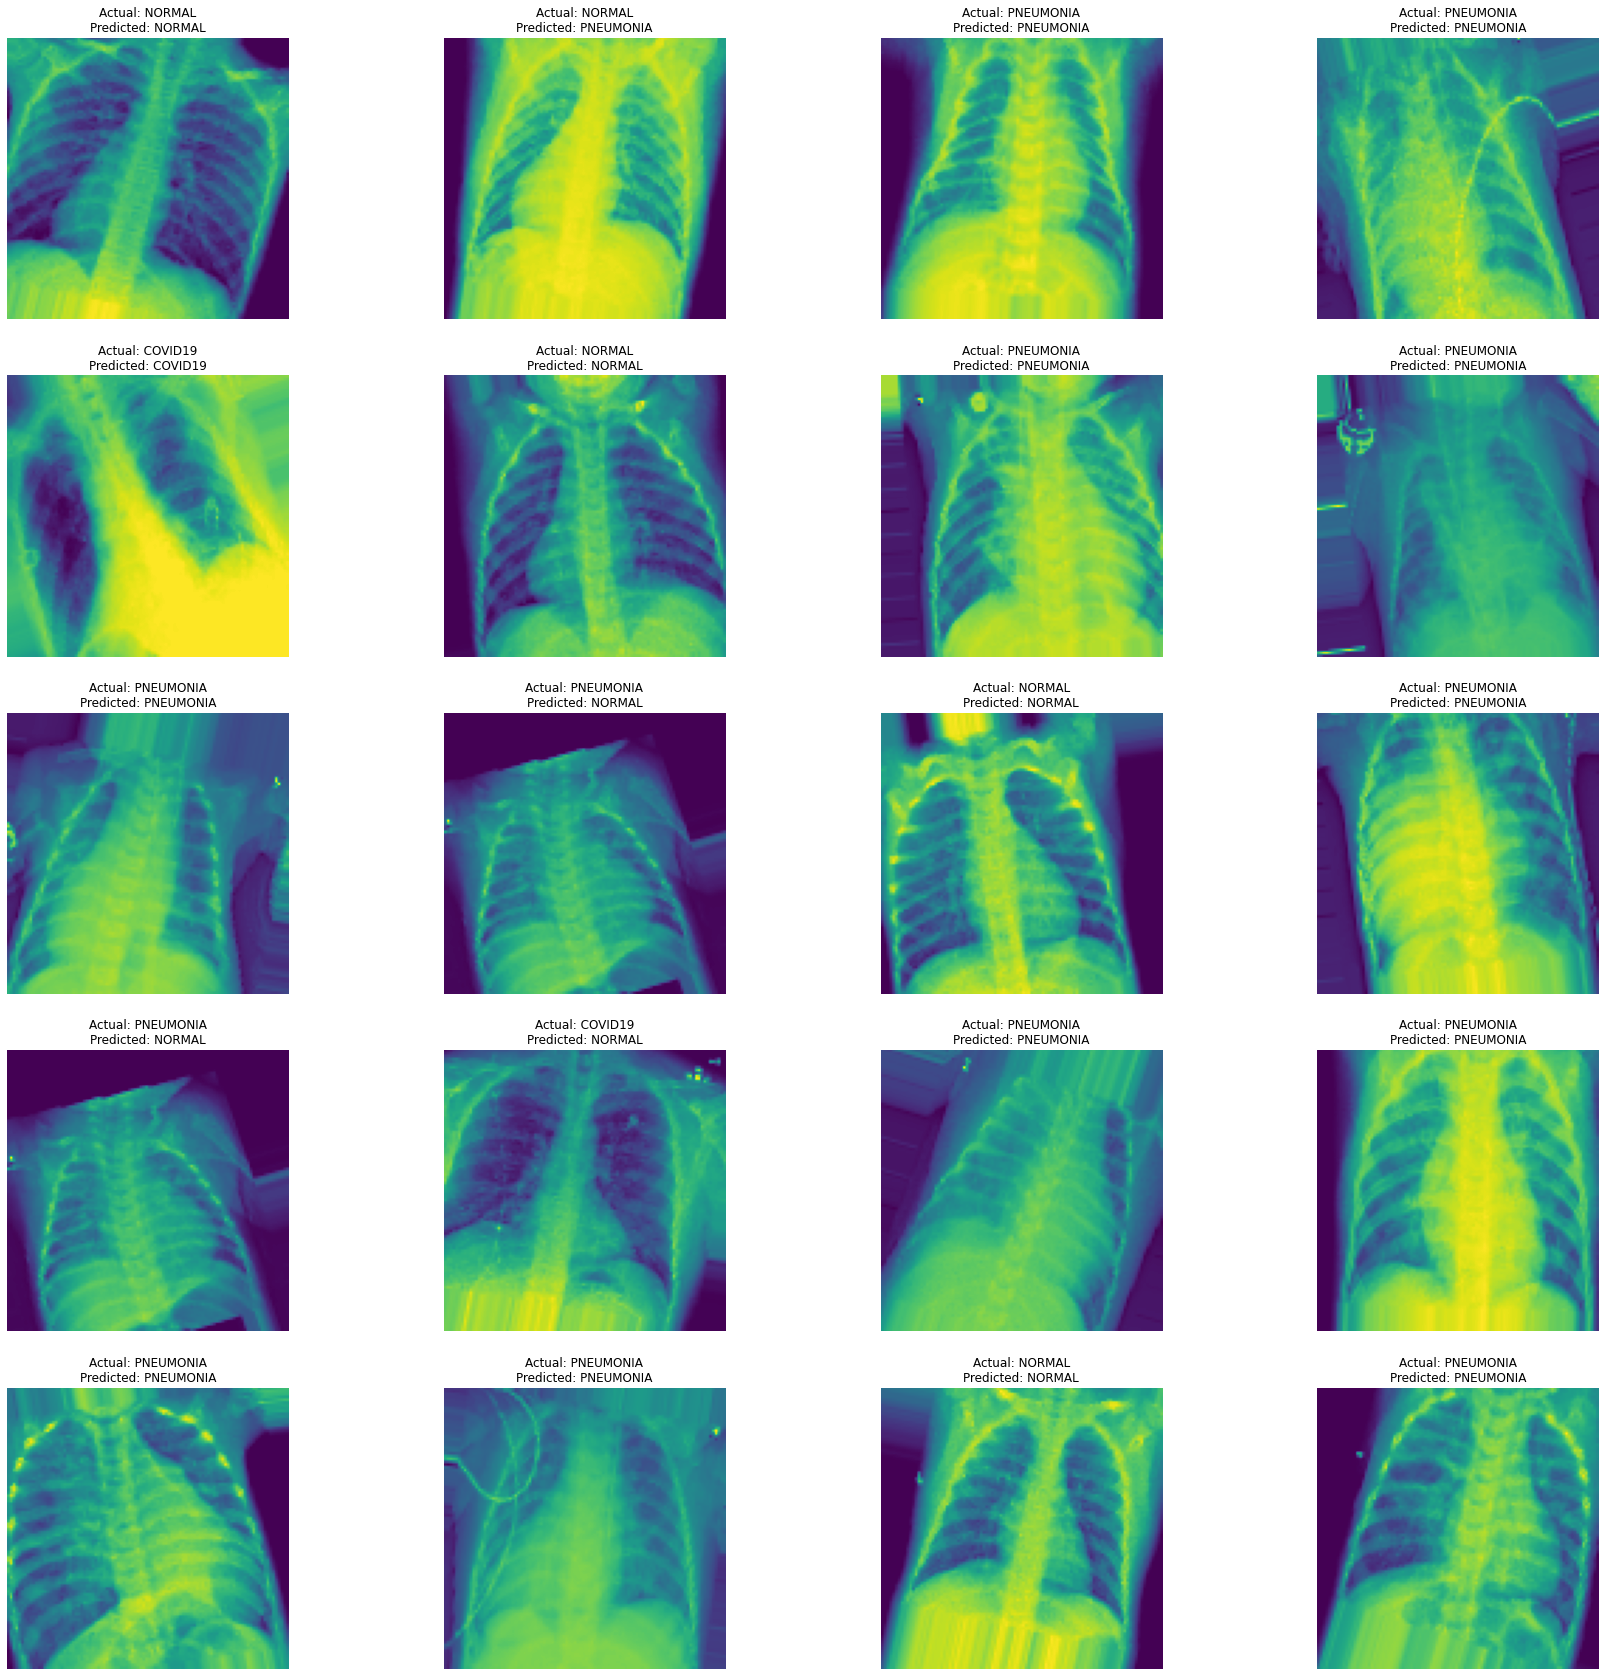

In [243]:
# 4. Sample image check

# Initialize a dictionary of classes
classes = {0 : 'COVID19', 1 : 'NORMAL', 2 : 'PNEUMONIA'}

# Initialize canvas
plt.figure(figsize = (30, 30))

print("\nSample images check from test data....\n")

for i in range(20):
  ind = random.randint(1288)
  plt.subplot(5, 4, i + 1)
  plt.title("Actual: " + str(classes[np.argmax(Label[ind])]) + "\nPredicted: " + str(classes[pred_classes[ind]]))
  plt.imshow(np.squeeze(Image[ind]))
  plt.axis('off')
  
plt.show()

In [244]:
# Save the model as a h5 file

cnn_covidxray_model.save("cnn_covidxray_model.h5")

**Notes:**

A simple CNN model resulted in an accuracy of 93+% on test dataset.

A random sample image check on the test dataset also supported the outcome.

Such CNN models are very powerful and useful in predicting pathologies from x rays. They can free up doctor's time by offering a preliminary diagnosis.